Imports

In [14]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

# pip install "shimmy>=2.0"

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

# Sodt Actor Critic codes from OpenAI for trajefctory generation
from stable_baselines3 import SAC
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Our functions

In [ ]:
from Train_policy_func import device # Policy, Policy_v2,
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies

# Training loop for OPPO
from pairs_generator import sample_preference_pairs
from DPO import DPO_training_sac as DPO_training



In [16]:
# need to redefine the functions to work with VecEnv
from Pendulum_functions import evaluate_policy_SAC as evaluate_policy
from Pendulum_functions import generate_sac_trajectory as generate_trajectory
from Pendulum_functions import sample_preference_pairs 
from Pendulum_functions import compute_logprob_trajectory_sac as compute_logprob_trajectory


Creating policies and changing seeds:

Evaluations over 10 episodes done for both policies


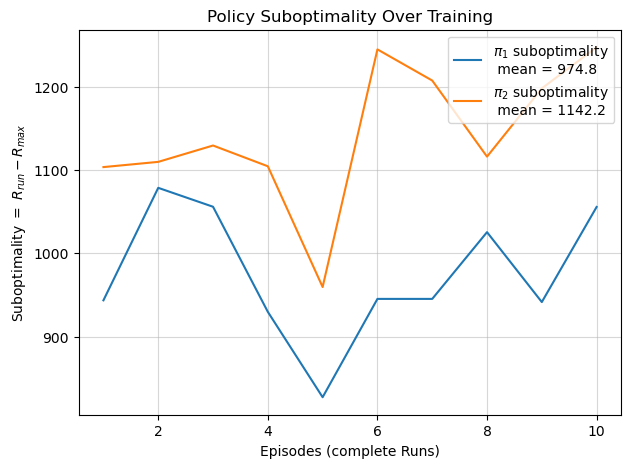

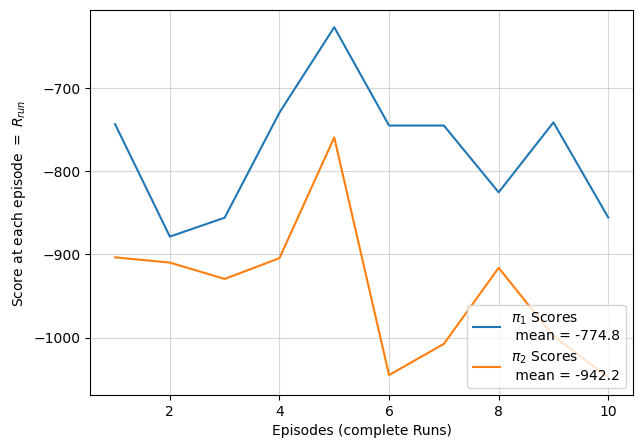

π₁ → length 200, total reward -236.8
π₂ → length 200, total reward -1078.9
Collected 10 preference pairs.
Epoch 0: DPO Loss = nan
Epoch 10: DPO Loss = nan
Epoch 20: DPO Loss = nan
Epoch 30: DPO Loss = nan
Epoch 40: DPO Loss = nan
Epoch 50: DPO Loss = nan
Epoch 60: DPO Loss = nan
Epoch 70: DPO Loss = nan
Epoch 80: DPO Loss = nan
Epoch 90: DPO Loss = nan
Epoch 100: DPO Loss = nan
Epoch 110: DPO Loss = nan
Epoch 120: DPO Loss = nan
Epoch 130: DPO Loss = nan
Epoch 140: DPO Loss = nan
Epoch 150: DPO Loss = nan
Epoch 160: DPO Loss = nan
Epoch 170: DPO Loss = nan
Epoch 180: DPO Loss = nan
Epoch 190: DPO Loss = nan
Epoch 200: DPO Loss = nan
Epoch 210: DPO Loss = nan
Epoch 220: DPO Loss = nan
Epoch 230: DPO Loss = nan
Epoch 240: DPO Loss = nan
Epoch 250: DPO Loss = nan
Epoch 260: DPO Loss = nan
Epoch 270: DPO Loss = nan
Epoch 280: DPO Loss = nan
Epoch 290: DPO Loss = nan
Epoch 300: DPO Loss = nan
Epoch 310: DPO Loss = nan
Epoch 320: DPO Loss = nan
Epoch 330: DPO Loss = nan
Epoch 340: DPO Loss =

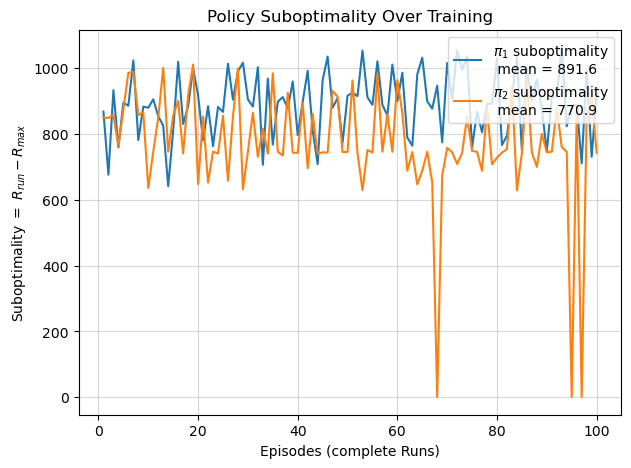

Evaluations over 10 episodes done for both policies


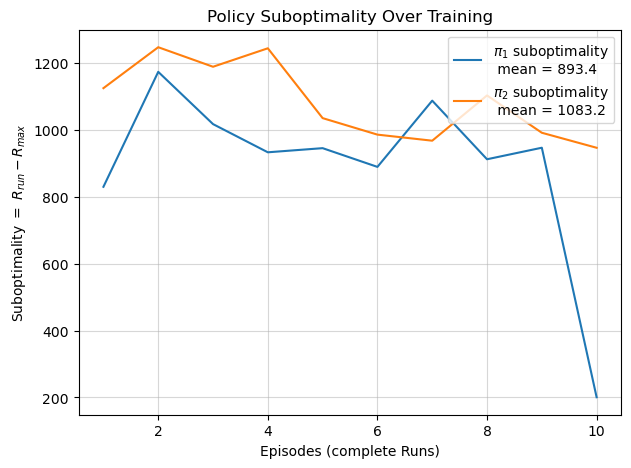

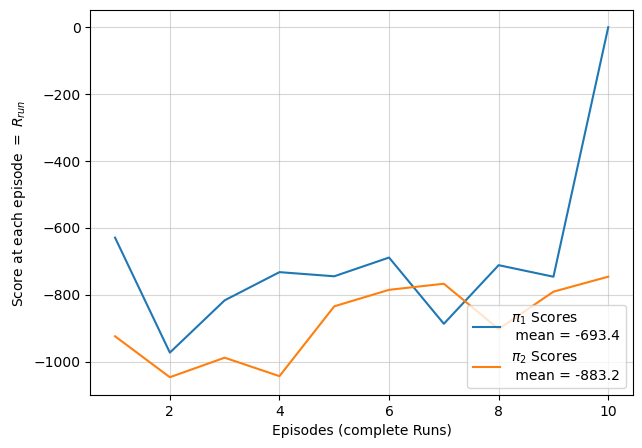

π₁ → length 200, total reward -238.4
π₂ → length 200, total reward -135.5
Collected 10 preference pairs.
Epoch 0: DPO Loss = nan
Epoch 10: DPO Loss = nan
Epoch 20: DPO Loss = nan
Epoch 30: DPO Loss = nan
Epoch 40: DPO Loss = nan
Epoch 50: DPO Loss = nan
Epoch 60: DPO Loss = nan
Epoch 70: DPO Loss = nan
Epoch 80: DPO Loss = nan
Epoch 90: DPO Loss = nan
Epoch 100: DPO Loss = nan


KeyboardInterrupt: 

In [17]:
seeds_list=[42] #100, 35
for seed in seeds_list:
    # Choose environment:

    # env 2: 
    env_name= 'Pendulum-v1'
    torch.manual_seed(seed)

    reward_threshold_pi1 = -140
    reward_threshold_pi2 = -600

    load_policies = True # USe True if policies have benn trained already

    # ── Hyperparams for sac ── See defaults in the code
    lr_SAC = 1e-3 # learning rate for SAC
    n_episodes              = 100 # keep same “number of iterations” for fair comparison
    TIMESTEPS               = 300  # cap on steps per episode
    print_every             = 1   # print every x episodes and avg also the score for every x episodes
    # gamma                   = 0.99

    seed_training_policies  = seed

    env_SAC = make_vec_env(env_name, n_envs=1, seed=seed_training_policies)
    model = SAC(policy="MlpPolicy", env=env_SAC,learning_rate=lr_SAC, verbose=0)





    # ── Run the SAC training ──
    if not load_policies:

        # Training the policy:
        for i in range(n_episodes):
            model.learn(total_timesteps=TIMESTEPS,reset_num_timesteps=False)
        
            if i % 1 == 0:
                mean_reward, std_reward = evaluate_policy(
                    model,
                    env_SAC,
                    n_eval_episodes=25,
                    deterministic=True,
                )
                print(f" at update {i}: Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
                if mean_reward > reward_threshold_pi2 and mean_reward < -450:
                    print(f"Saving model pi2 at {mean_reward}")
                    # model.save(f"{models_dir}/pi2-{TIMESTEPS*i}")
                    model.save(f"pi2_SAC_{env_name}_seed_{seed}.pth") 
                elif mean_reward > reward_threshold_pi1:
                    print(f"Saving model pi1 at {mean_reward}")
                    # model.save(f"{models_dir}/pi1-{TIMESTEPS*i}")
                    model.save(f"pi1_SAC_{env_name}_seed_{seed}.pth")   
                    break

    # ── Load the policies ──
    pi1_SAC = MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule ).to(device)
    pi2_SAC = MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule, ).to(device)
 
    model1 = SAC.load(f"pi1_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    pi1_SAC = model1.policy
    model2 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    pi2_SAC = model2.policy


    # ── Create trajectories ──
    num_episodes = 10
    
    pi1_mean_reward, pi1_reward = evaluate_policy(pi1_SAC, env_SAC, n_episodes=num_episodes,device=device)
    pi2_mean_reward, pi2_reward = evaluate_policy(pi2_SAC, env_SAC, n_episodes=num_episodes,device=device)
    print("Evaluations over", num_episodes, "episodes done for both policies")

    plot_suboptimality(
        pi1_reward,
        pi2_reward,
        max_reward=200, # for CartPole-v0
    )

    plot_Scores(
        pi1_reward,
        pi2_reward,
    )
    traj1 = generate_trajectory(pi1_SAC, env_SAC, max_steps=1000)
    traj2 = generate_trajectory(pi2_SAC, env_SAC, max_steps=1000)

    print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
    print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
    K=10
    prefs = sample_preference_pairs(pi1_SAC, pi2_SAC, env_SAC, K=K) # Need to define K elsewhere as hyperparameter
    print(f"Collected {len(prefs)} preference pairs.")
    lr_DPO=0.01

    policy_DPO= MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule ).to(device)
    policy_ref=pi1_SAC
    #policy_ref=pi2_oppo

    opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)
    model3 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    policy_DPO = model3.policy
    #policy_DPO.load_state_dict(torch.load(f"pi1_SAC_{env_name}_seed_{seed}.pth"))

    beta=0.5

    DPO_training(policy_DPO,policy_ref,prefs,beta,opt_DPO,nb_epochs=400)
    torch.save(policy_DPO.state_dict(), f"pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}.pth")
    print(f"Saved final policy as pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}.pth")
    num_episodes = 100
    pi1_mean_reward, pi1_reward = evaluate_policy(policy_DPO, env_SAC, n_episodes=num_episodes)
    pi2_mean_reward, pi2_reward = evaluate_policy(policy_ref, env_SAC, n_episodes=num_episodes)

    plot_suboptimality(
        pi1_reward,
        pi2_reward,
        0, # for Pendulum-v1
    )  


    # ── Load the policies ──
    pi1_SAC = MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule ).to(device)
    pi2_SAC = MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule, ).to(device)
 
    model1 = SAC.load(f"pi1_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    pi1_SAC = model1.policy
    model2 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    pi2_SAC = model2.policy

    # ── Create trajectories ──
    num_episodes = 10
    pi1_mean_reward, pi1_reward = evaluate_policy(pi1_SAC, env_SAC, n_episodes=num_episodes)
    pi2_mean_reward, pi2_reward = evaluate_policy(pi2_SAC, env_SAC, n_episodes=num_episodes)
    print("Evaluations over", num_episodes, "episodes done for both policies")

    plot_suboptimality(
        pi1_reward,
        pi2_reward,
        max_reward=200, # for CartPole-v0
    )

    plot_Scores(
        pi1_reward,
        pi2_reward,
    )
    traj1 = generate_trajectory(pi1_SAC, env_SAC, max_steps=1000)
    traj2 = generate_trajectory(pi2_SAC, env_SAC, max_steps=1000)

    print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
    print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
    K=10
    prefs = sample_preference_pairs(pi1_SAC, pi2_SAC, env_SAC, K=K) # Need to define K elsewhere as hyperparameter
    print(f"Collected {len(prefs)} preference pairs.")
    lr_DPO=0.01

    policy_DPO= MlpPolicy(env_SAC.observation_space, env_SAC.action_space, model.lr_schedule ).to(device)
    policy_ref=pi1_SAC
    #policy_ref=pi2_oppo

    opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)
    model3 = SAC.load(f"pi2_SAC_{env_name}_seed_{seed}.pth", env=env_SAC, device=device)
    policy_DPO = model3.policy

    beta=0.5

    DPO_training(policy_DPO,policy_ref,prefs,beta,opt_DPO,nb_epochs=400)
    torch.save(policy_DPO.state_dict(), f"pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}.pth")
    print(f"Saved final policy as pi_DPO_{env_name}_seed_{seed}_beta{beta}_K{K}.pth")
    num_episodes = 10
    pi1_mean_reward, pi1_reward = evaluate_policy(policy_DPO, env_SAC, n_episodes=num_episodes)
    pi2_mean_reward, pi2_reward = evaluate_policy(policy_ref, env_SAC, n_episodes=num_episodes)

    plot_suboptimality(
        pi1_reward,
        pi2_reward,
        200,
    )  # in cartpole, 200 is the maximum reward



Averaging over the different seeds

In [ ]:
file_pi1=[f"pi1_SAC_{env_name}_seed_{seed}.pth"]
file_pi2=[f"pi2_SAC_{env_name}_seed_{seed}.pth"]
file_pi_DPO=[f"pi_DPO_SAC_{env_name}_seed_{seed}.pth",f"pi_DPO_oppo_{env_name}_seed_{seed}_K200.pth",f"pi_DPO_oppo_{env_name}_seed_{seed}_beta0.005.pth",f"pi_DPO_oppo_{env_name}_seed_{seed}_beta1_invverted.pth"]

import torch
import numpy as np
import os

def load_policy(file_path, state_dim, action_dim, device="cpu"):
    policy = Policy(state_size=state_dim, action_size=action_dim).to(device)
    policy.load_state_dict(torch.load(file_path, map_location=device))
    return policy

def evaluate_all_policies(env, seeds, env_name, num_episodes=10, device="cpu"):
    results = {}

    # === PI1 and PI2 (vary by seed) ===
    for label in ["pi1", "pi2"]:
        returns = []
        rewards_list=np.zeros(num_episodes)
        for seed in seeds:
            file_path = f"{label}_oppo_{env_name}_seed_{seed}.pth"
            if not os.path.exists(file_path):
                print(f"Missing file: {file_path}")
                continue

            policy = load_policy(file_path, env.observation_space.shape[0], env.action_space.n, device)
            mean_return, rewards_per_ep = evaluate_policy(policy, env, n_episodes=num_episodes)
            returns.append(mean_return)
            rewards_list+=rewards_per_ep
        results[label] = {
            "mean": np.mean(returns),
            "std": np.std(returns),
            "per_seed": returns,
            "graph":rewards_list/len(seeds)
        }

    # === PI_DPO variants (filename includes other params) ===
    pi_DPO_files = [
        f"pi_DPO_{env_name}_seed_{seed}.pth",
        f"pi_DPO_{env_name}_seed_{seed}_K200.pth",
        f"pi_DPO_{env_name}_seed_{seed}_beta0.005.pth",
        f"pi_DPO_{env_name}_seed_{seed}_beta0.5_K10.pth",
        f"pi_DPO_{env_name}_seed_{seed}_beta1_inverted.pth"
    ]

    for file_template in pi_DPO_files:
        label = os.path.splitext(file_template)[0].replace("pi_DPO_oppo_", "").replace("_seed_{seed}", "")
        returns = []
        rewards_list=np.zeros(num_episodes)
        for seed in seeds:
            file_path = file_template#.format(seed=seed)
            # if not os.path.exists(file_path):
            #     print(f"Missing file: {file_path}")
            #     continue

            policy = load_policy(file_path, env.observation_space.shape[0], env.action_space.n, device)
            mean_return, rewards_per_ep = evaluate_policy(policy, env, n_episodes=num_episodes)
            returns.append(mean_return)
            rewards_list+=rewards_per_ep
        results[f"pi_DPO_{label}"] = {
            "mean": np.mean(returns),
            "std": np.std(returns),
            "per_seed": returns,
            "graph":rewards_list/len(seeds)
        }

    return results



In [ ]:
results=evaluate_all_policies(env_oppo,seeds_list,env_name,50)

C:\Users\youss\AppData\Local\Temp\ipykernel_15996\2323423716.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(file_path, map_location=d

dict_keys(['pi1', 'pi2', 'pi_DPO_pi_DPO_CartPole-v0_seed_35', 'pi_DPO_pi_DPO_CartPole-v0_seed_35_K200', 'pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.005', 'pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.5_K10', 'pi_DPO_pi_DPO_CartPole-v0_seed_35_beta1_inverted'])


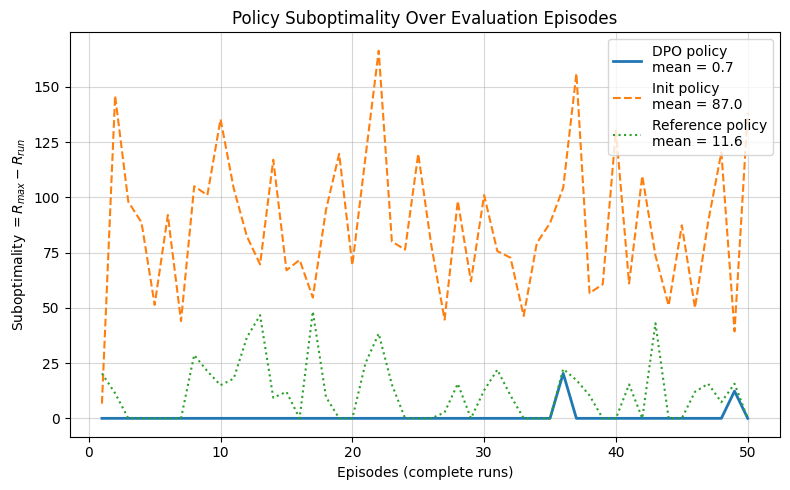

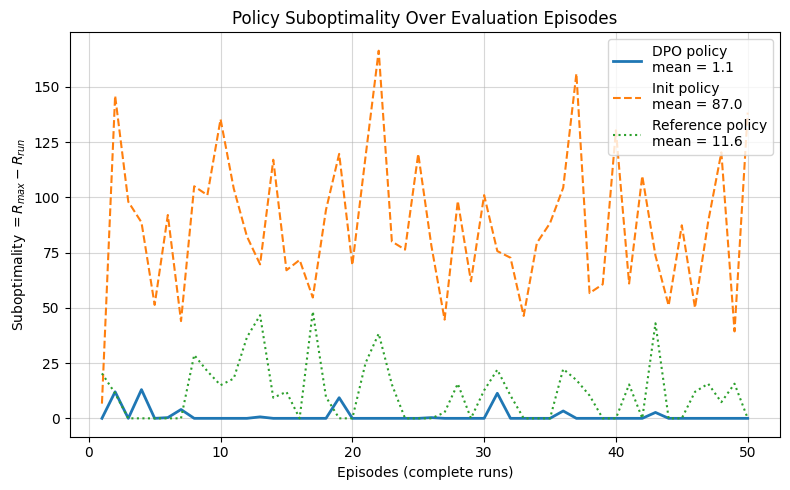

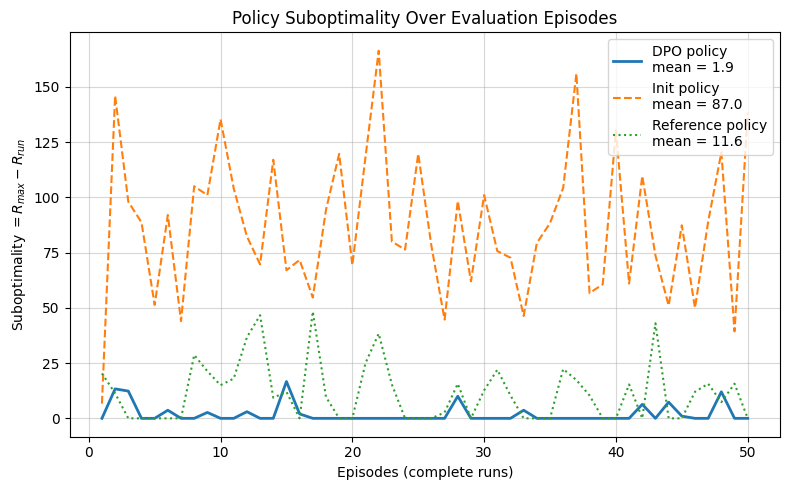

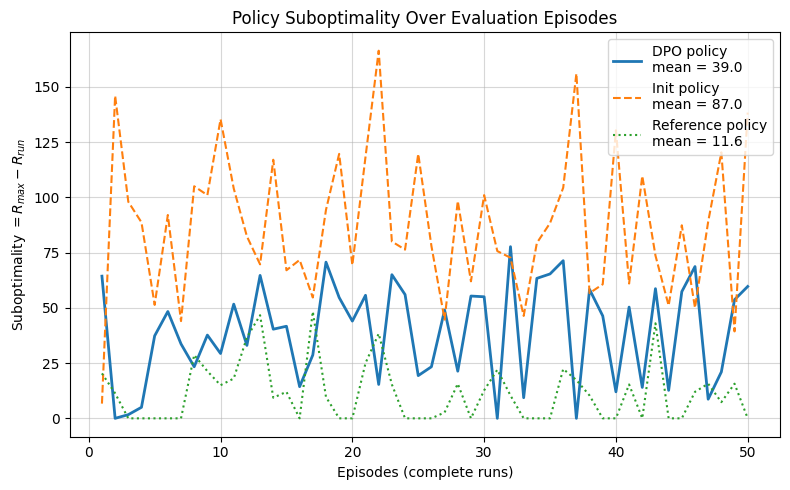

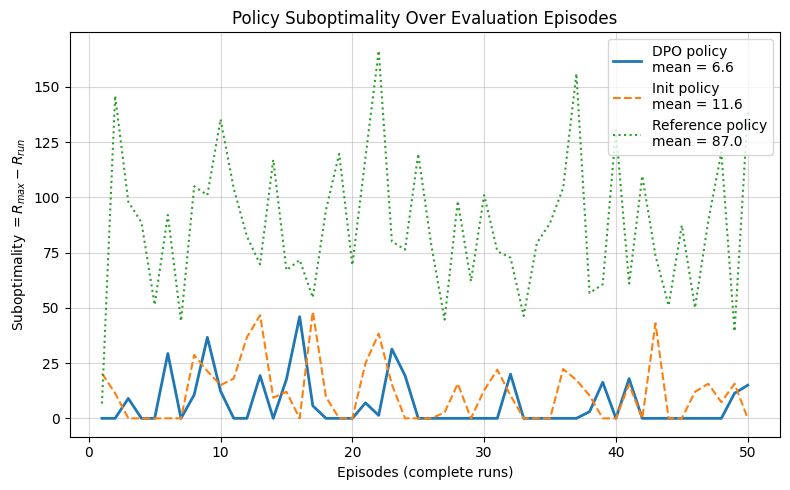

In [ ]:
# Example labels: 'pi_DPO_', 'pi1', 'pi2'
print(results.keys())
reward_hist_init = results["pi2"]["graph"]
reward_hist_ref = results["pi1"]["graph"]
reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35"]["graph"]

plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)

reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_K200"]["graph"]

plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)
reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.005"]["graph"]

plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)
reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta0.5_K10"]["graph"]

plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)


reward_hist_dpo = results["pi_DPO_pi_DPO_CartPole-v0_seed_35_beta1_inverted"]["graph"]
reward_hist_init = results["pi1"]["graph"]
reward_hist_ref = results["pi2"]["graph"]
plot_suboptimality_three_policies(reward_hist_dpo, reward_hist_init, reward_hist_ref, max_reward=200)